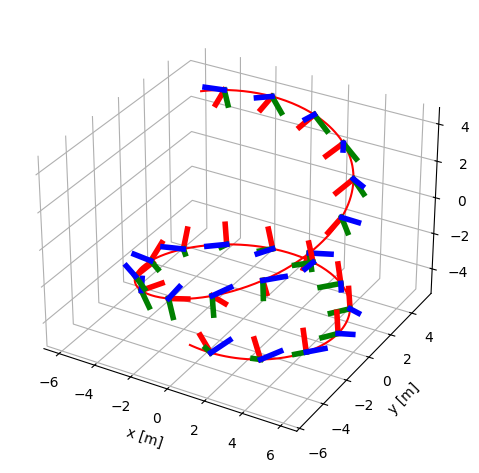

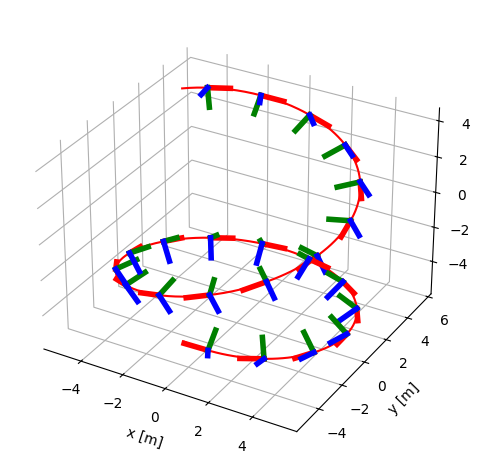

In [1]:
import numpy as np
import math
from numpy import sin, cos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import 3D toolkit
# from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go

def skew(v):
    v = v.reshape((3,))
    vsk = np.array([[ 0,    -v[2],  v[1]],
                    [ v[2],  0,    -v[0]],
                    [-v[1],  v[0],  0   ]]).reshape((3,3))
    return vsk

def g(V):
    Vp2 = V*V
    return (1 - cos(V))/Vp2

def SO3Exp(v):
    V = np.linalg.norm(v)
    u = v/V
    R = np.identity(3) + sin(V)*skew(u) + g(V)*skew(v)@skew(v)
    return R

dt = 0.05
lie_tolerance = 1e-2

t = np.arange(0, 69/3, dt)

wqx1 = 3*0.1
wqy1 = 3*0.1
wqz1 = 1*0.1

rqx1 = math.pi*0.5
rqy1 = math.pi*0.5
rqz1 = math.pi*math.sqrt(3)/2

wpx1 = 3*0.15
wpy1 = 3*0.15
wpz1 = 1*0.15
rpx1 = 5.0
rpy1 = 5.0
rpz1 = 5.0

def SO3xR3Traj(t, der=0):
    if der == 0: 
        thetax = rqx1*np.cos(wqx1*t + 57)
        thetay = rqy1*np.sin(wqy1*t + 57)
        thetaz = rqz1*np.sin(wqz1*t + 43)
        px = rpx1*np.sin(wpx1*t + 43)
        py = rpy1*np.cos(wpy1*t + 43)
        pz = rpz1*np.cos(wpz1*t + 57)
        return thetax, thetay, thetaz, px, py, pz
    elif der == 1:
        thetadx = -rqx1*wqx1*np.sin(wqx1*t + 57)
        thetady =  rqy1*wqy1*np.cos(wqy1*t + 57)
        thetadz =  rqz1*wqz1*np.cos(wqz1*t + 43)
        vx =  rpx1*wpx1*np.cos(wpx1*t + 43)
        vy = -rpy1*wpx1*np.sin(wpy1*t + 43)
        vz = -rpz1*wpx1*np.sin(wpz1*t + 57)
        return thetadx, thetady, thetadz, vx, vy, vz

def SE3Traj(ts):
    
    px = rpx1*sin(wpx1*ts + 43)
    py = rpy1*cos(wpy1*ts + 43)
    pz = rpz1*cos(wpz1*ts + 57)
    # p = np.vstack((px, py, pz))
    vx =  rpx1*wpx1*np.cos(wpx1*ts + 43)
    vy = -rpy1*wpy1*np.sin(wpy1*ts + 43)
    vz = -rpz1*wpz1*np.sin(wpz1*ts + 57)
    
    # ex = []
    # ey = []
    # ez = []
    
    ex = np.array([vx, vy, vz]).reshape((3, 1))
    ex = ex/np.linalg.norm(ex)
    rn = np.array([px, py, pz]).reshape((3, 1))
    rn = rn/np.linalg.norm(rn)
    ez = skew(rn)@ex
    ey = skew(ez)@ex
    # ex.append(np.squeeze(ex))
    # ey.append(np.squeeze(ey))
    # ez.append(np.squeeze(ez))
    
    return np.squeeze(ex), np.squeeze(ey), np.squeeze(ez), px, py, pz

thetax, thetay, thetaz, px, py, pz = SO3xR3Traj(t)
theta = np.vstack((thetax, thetay, thetaz))
# p = np.stack((px, py, pz))

thetadx, thetady, thetadz, vx, vy, vz = SO3xR3Traj(t, 1)
thetad = np.vstack((thetadx, thetady, thetadz))
# v  = np.stack((px, py, pz))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Light red-ish
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Light green-ish
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Light blue-ish

ax.plot(px, py, pz, color='r')
# ax.grid(False)
# ax.set_axis_off()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
for ts in np.arange(0.5, 69/3, 1):
    thetax, thetay, thetaz, px, py, pz = SO3xR3Traj(ts, der=0)
    theta = np.array([thetax, thetay, thetaz]).reshape((3,1))
    R = SO3Exp(theta)
    ex, ey, ez = R[:, 0], R[:, 1], R[:, 2]
    ax.plot([px, px + ex[0]], [py, py + ex[1]], [pz, pz + ex[2]], color='r', linewidth=4)
    ax.plot([px, px + ey[0]], [py, py + ey[1]], [pz, pz + ey[2]], color='g', linewidth=4)
    ax.plot([px, px + ez[0]], [py, py + ez[1]], [pz, pz + ez[2]], color='b', linewidth=4)   

# ax.view_init(elev=30, azim=25)

fig.tight_layout()
fig.savefig(f'so3xr3_trajgtr.jpg', bbox_inches='tight', pad_inches=0.1, dpi=300)





fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Light red-ish
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Light green-ish
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Light blue-ish

px = []
py = []
pz = []
for ts in t:
    _, _, _, px_, py_, pz_ = SE3Traj(ts)
    px.append(px_)
    py.append(py_)
    pz.append(pz_)

ax.plot(px, py, pz, color='r')
# ax.grid(False)
# ax.set_axis_off()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
for ts in np.arange(0.5, 69/3, 1):
    ex, ey, ez, px, py, pz = SE3Traj(ts)
    ax.plot([px, px + ex[0]], [py, py + ex[1]], [pz, pz + ex[2]], color='r', linewidth=4)
    ax.plot([px, px + ey[0]], [py, py + ey[1]], [pz, pz + ey[2]], color='g', linewidth=4)
    ax.plot([px, px + ez[0]], [py, py + ez[1]], [pz, pz + ez[2]], color='b', linewidth=4)   
# plt.show()
fig.tight_layout()
fig.savefig(f'se3_trajgtr.jpg', bbox_inches='tight', pad_inches=0.1, dpi=300)

    

In [2]:
# dthetax = (thetax[1:] - thetax[0:-1])
# dthetay = (thetay[1:] - thetay[0:-1])
# dthetaz = (thetaz[1:] - thetaz[0:-1])
# dtheta  = np.vstack((dthetax, dthetay, dthetaz))

# fig, ax = plt.subplots()
# ax.plot(t,  np.ones_like(t)*lie_tolerance, 'b')
# ax.plot(t, -np.ones_like(t)*lie_tolerance, 'b')
# ax.plot(t[1:], dthetax, 'r')
# ax.set_xlim([0, min(20, t[-1])])
# ax.set_ylabel('dthetax')
# ax.set_xlabel('t [s]')

# fig, ax = plt.subplots()
# ax.plot(t, thetadx, 'r')
# ax.set_xlim([0, min(20, t[-1])])
# ax.set_ylabel('thetadx')
# ax.set_xlabel('t [s]')

# fig, ax = plt.subplots()
# ax.plot(t, vx, 'r')
# ax.set_xlim([0, min(20, t[-1])])
# ax.set_ylabel('vx')
# ax.set_xlabel('t [s]')

In [3]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Create figure and 3D axes
# fig = plt.figure()
# fig.patch.set_facecolor('lightgray')  # Outer figure background

# ax = fig.add_subplot(111, projection='3d')
# ax.set_facecolor('white')  # Axes (plot area) background

# # Optional: customize pane (side walls) colors
# ax.xaxis.set_pane_color((1.0, 0.9, 0.9, 1.0))  # Light red-ish
# ax.yaxis.set_pane_color((0.9, 1.0, 0.9, 1.0))  # Light green-ish
# ax.zaxis.set_pane_color((0.9, 0.9, 1.0, 1.0))  # Light blue-ish

# # Dummy plot
# x = np.linspace(0, 10, 100)
# y = np.sin(x)
# z = np.cos(x)
# ax.plot(x, y, z, color='blue')

# plt.show()
